# Graph Embeddings

In this notebook, we illustrate several graph embedding algorithms, we show how we can compare embeddings using an unsupervised framework, and we look at various applications such as visualization, clustering, link prediction and classification.

### Things to install:

We use a Julia package from https://github.com/KrainskiL/CGE.jl to compare graph embeddings.

Results presented in the book were run on MacOS. Most results are identical on Linux (we use seeds), but we found that Node2Vec can yield slightly different results. This can lead to small differences in some results, but not in the conclusions. 

Set the path(s) in the cell below. 

In [1]:
## the data directory
datadir = "Datasets/"

"Datasets/"

In [2]:
using PythonCall

    CondaPkg Found dependencies: /Users/ryandewolfe/2026_MIT_18.S097_Introduction-to-Julia-for-Data-Science/CondaPkg.toml
    CondaPkg Found dependencies: /Users/ryandewolfe/.julia/packages/CondaPkg/0UqYV/CondaPkg.toml
    CondaPkg Found dependencies: /Users/ryandewolfe/.julia/packages/PythonCall/83z4q/CondaPkg.toml
    CondaPkg Found dependencies: /Users/ryandewolfe/.julia/packages/PythonPlot/oS8x4/CondaPkg.toml
    CondaPkg Initialising pixi
             │ /Users/ryandewolfe/.julia/artifacts/d2fecc2a9fa3eac2108d3e4d9d155e6ff5dfd0b2/bin/pixi
             │ init
             │ --format pixi
             └ /Users/ryandewolfe/2026_MIT_18.S097_Introduction-to-Julia-for-Data-Science/.CondaPkg
✔ Created /Users/ryandewolfe/2026_MIT_18.S097_Introduction-to-Julia-for-Data-Science/.CondaPkg/pixi.toml
    CondaPkg Wrote /Users/ryandewolfe/2026_MIT_18.S097_Introduction-to-Julia-for-Data-Science/.CondaPkg/pixi.toml
             │ [dependencies]
             │ openssl = ">=3, <3.6"
             │ f

In [3]:
using Arpack
using CGE
using CSV, DataFrames
using DelimitedFiles
using Graphs
using GraphMakie, GLMakie
using LinearAlgebra
using NetworkLayout
using Plots
using Random
using StatsBase
using UMAP

# A few useful functions

In [4]:
## read embedding from disk, in node2vec format
function readEmbedding(fn::String="_embed", sort::Bool=true)
    df = CSV.File(fn; delim=' ', header=false, skipto=2) |> DataFrame
    # Drop any columns that are entirely missing
    df = df[:, all.(!ismissing, eachcol(df))]
    sort && sort!(df, :Column1)
    y = Matrix(df[:, 2:end])
    return y
end

## Read embedding from file in node2vec format
## Map to 2d layout format, using UMAP if dim > 2
function embed2layout(fn::String="_embed", seed::Int=123, n_jobs::Int=1)
    df = CSV.File(fn; delim=' ', header=false, skipto=2) |> DataFrame
    df = df[:, all.(!ismissing, eachcol(df))]
    sort!(df, :Column1)  # sort by first column
    y = Matrix(df[:, 2:end])

    if size(y, 2) > 2
        Random.seed!(seed)
        y = umap(y', 2)
        y = y'
    end
    return Tuple.(eachrow(Matrix(y)))
end

## Computing Jensen-Shannon (JS) divergence with the Julia CGE framework code
## given files: edgelist, communities and embedding
function JS(edge_file, comm_file, embed_file, return_local=true, seed=123)
    out = Pipe()
    cmd = `julia --project CGE_CLI.jl -g $(edge_file) -c $(comm_file) -e $(embed_file) --seed $(string(seed))`
    run(pipeline(cmd, stdout=out, stderr=Pipe()))
    close(out.in)
    result = String(read(out))
    x = parse.(Float64, split(result[2:end-2], ", "))
    return_local && return (x[2], x[6])
    return x[2]
end

## save embedding to disk to compute divergence with Julia CGE framework
function saveEmbedding(x::AbstractMatrix, g, fn::String="_embed")
    open(fn, "w") do f
        println(f, "$(size(x, 1)) $(size(x, 2))")
        for i in 1:size(x, 1)
            print(f, i - 1, " ")
            for j in 1:size(x, 2)
                print(f, x[i, j], " ")
            end
            print(f, "\n")
        end
    end
end


## Hope embedding with various similarity functions

function Hope(g::AbstractGraph, sim::String="katz", dim::Int=2, verbose::Bool=false, beta::Float64=0.01, alpha::Float64=0.5)
    if !is_directed(g)
        dim *= 2
    end

    a = Matrix(adjacency_matrix(g))
    n = nv(g)
    m_g = I
    m_l = I

    if sim == "katz"
        m_g = I - beta * a
        m_l = beta * a
    elseif sim == "aa"
        m_g = I
        d = Diagonal([x > 1 ? 1 / log(x) : 0.0 for x in degree(g)])
        m_l = a * d * a
        m_l[diagind(m_l)] .= 0.0
    elseif sim == "cn"
        m_g = I
        m_l = a * a
    elseif sim == "ppr"
        p = zeros(n, n)
        for i in 1:n
            s = sum(a[i, :])
            if s > 0
                p[i, :] = a[i, :] ./ s
            else
                p[i, :] .= 1 / n
            end
        end
        p = transpose(p)
        m_g = I - alpha * p
        m_l = (1 - alpha) * I
    end

    s = inv(m_g) * m_l
    u, s_svd, v = svd(s)
    k = dim ÷ 2
    u = u[:, begin:k]
    s_svd = s_svd[begin:k]
    v = v[begin:k, :]
    sqrt_s = Diagonal(sqrt.(s_svd))
    x1 = u * sqrt_s
    x2 = v' * sqrt_s
    x = hcat(x1, x2)

    p_d_p_t = u * Diagonal(s_svd) * v
    eig_err = norm(p_d_p_t - s)

    if verbose
        println("SVD error (low rank): $eig_err")
    end

    if !is_directed(g)
        d = dim ÷ 2
        return x[:, 1:d]
    else
        return x
    end
end


## Laplacian eigenmaps embedding
function LE(g, dim::Int=2)
    adjmat = Graphs.LinAlg.CombinatorialAdjacency(adjacency_matrix(g))
    l_sym = Matrix(I - Diagonal(adjmat.D .^ (-1 / 2)) * (adjmat.A) * Diagonal(adjmat.D .^ (-1 / 2)))
    w, v = eigs(l_sym, nev=dim + 1, which=:SM)  # Smallest magnitude eigenvalues
    idx = sortperm(real(w))  # Sort eigenvalues
    w = w[idx]
    v = v[:, idx]
    x = v[:, 2:end]
    return x
end

# ## Returns a LaTeX bmatrix
function bmatrix(a::AbstractArray)
    if ndims(a) > 2
        throw(ArgumentError("bmatrix can at most display two dimensions"))
    end

    lines = split(replace(string(a), ['[', ']'] => ""), '\n')
    rv = [raw"\begin{bmatrix}"]
    append!(rv, ["  " * join(split(l), " & ") * raw"\\" for l in lines])
    push!(rv, raw"\end{bmatrix}")
    return join(rv, "\n")
end

## plot graph without axes and background grid
function clean_graphplot(g::AbstractGraph; kwargs...)
    f, ax, p = graphplot(g; kwargs...)
    hidedecorations!(ax)
    hidespines!(ax)
    return f
end

clean_graphplot (generic function with 1 method)

# Figure 6.2 in the Book

This is to illustrate random walks on (directed) graphs.


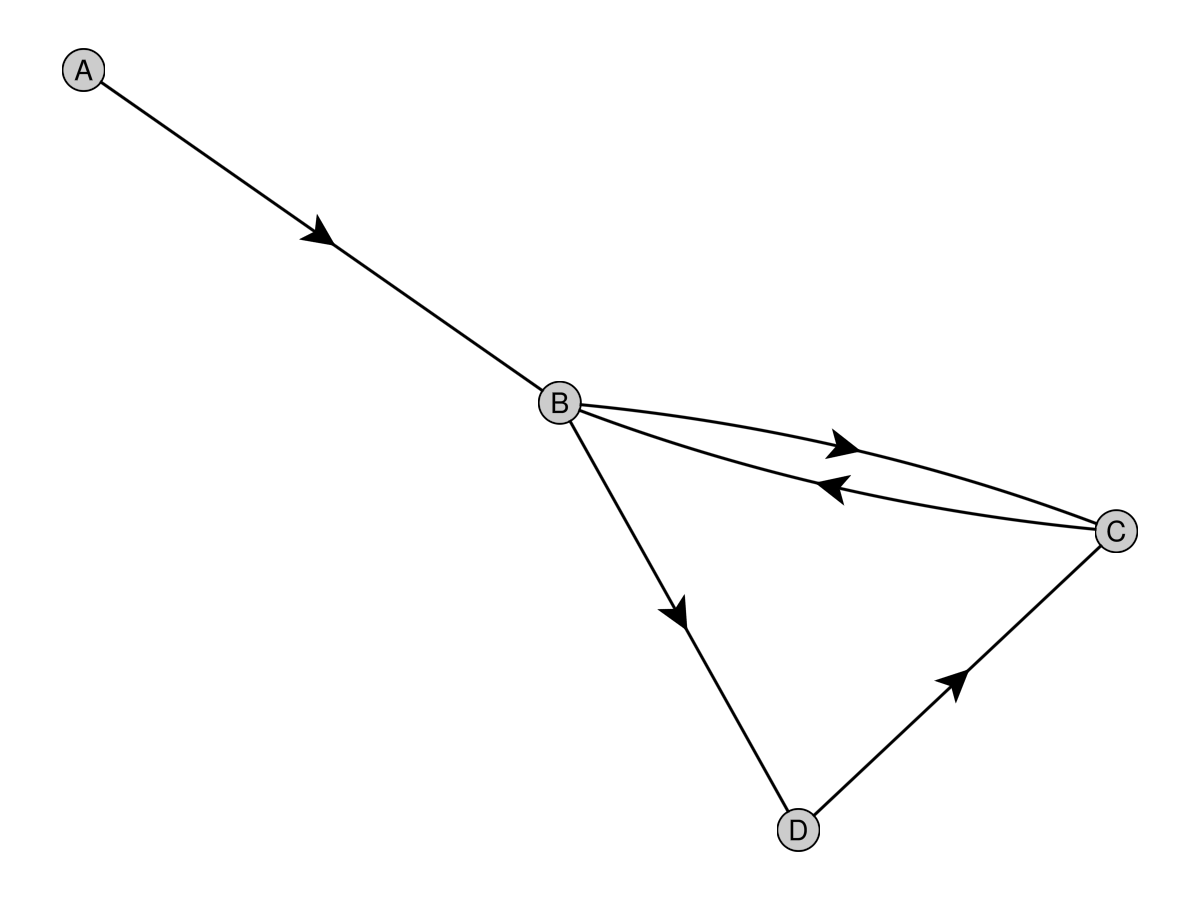

In [5]:
g = SimpleDiGraph(4)
for e in [(1, 2), (2, 3), (2, 4), (3, 2), (4, 3)]
    add_edge!(g, e...)
end

clean_graphplot(g,
    node_size=20,
    ilabels=["A", "B", "C", "D"],
    arrow_size=25)

# Datasets

* ```abcd```: is a small ABCD graph (100 nodes), mainly for visualization and quick examples
* ```ABCD1```: is a larger ABCD graph (1000 nodes), for experiments. It is noisy with $\xi=0.6$.
* ```ABCD2```: Similar to ```ABCD1``` but less noisy with $\xi=0.2$.
* ```zac```: Zachary (karate club) graph, mainly for visualzation

The small ```abcd``` graph was generated with the following parameters:

```
n = "100"                     # number of vertices in graph
t1 = "3"                      # power-law exponent for degree distribution
d_min = "5"                   # minimum degree
d_max = "15"                  # maximum degree
d_max_iter = "1000"           # maximum number of iterations for sampling degrees
t2 = "2"                      # power-law exponent for cluster size distribution
c_min = "25"                  # minimum cluster size
c_max = "50"                  # maximum cluster size
xi = "0.2"                    # fraction of edges to fall in background graph
```

The larger ```ABCD1``` and ```ABCD2``` graphs were generated with the following parameters:

```
n = "1000"                     # number of vertices in graph
t1 = "3"                       # power-law exponent for degree distribution
d_min = "10"                   # minimum degree
d_max = "100"                  # maximum degree
d_max_iter = "1000"            # maximum number of iterations for sampling degrees
t2 = "2"                       # power-law exponent for cluster size distribution
c_min = "50"                   # minimum cluster size
c_max = "150"                  # maximum cluster size
xi = "0.6" or "0.2"            # fraction of edges to fall in background graph
```


### Load the small ABCD graph and visualize

Beware: node names are 1-based and are distinct from vertex ids.

100 vertices, 350 edges, mean degree: 7.0, no. of communities: 3


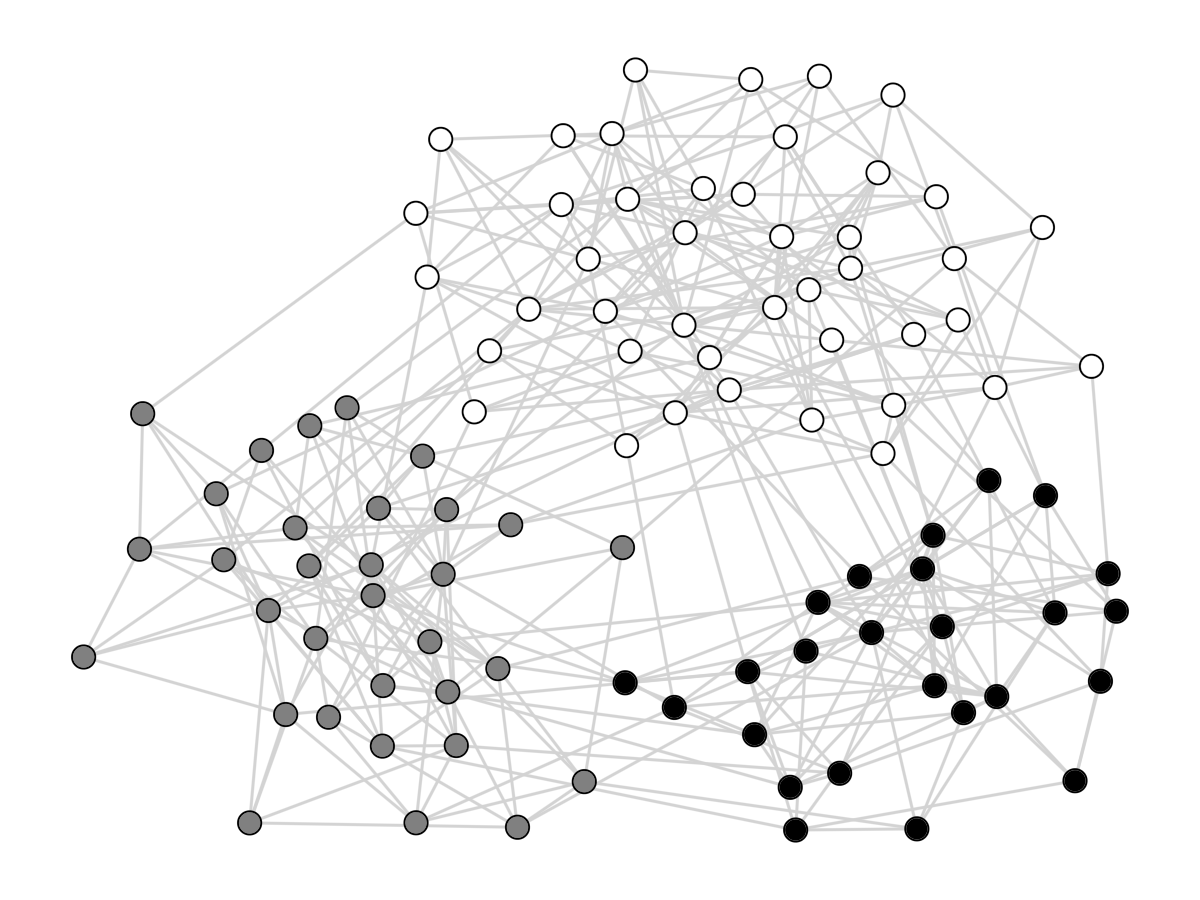

In [6]:
## read graph and communities
abcd_edgelist = readdlm(datadir * "abcd_100.dat", Int)
c_abcd = readdlm(datadir * "abcd_100_comms.dat", Int)[:, 2]
n = length(c_abcd)

abcd = SimpleGraph(n)
for row in eachrow(abcd_edgelist)
    add_edge!(abcd, row...)
end

## print a few stats
println(nv(abcd), " vertices, ", ne(abcd), " edges, ", "mean degree: ", mean(degree(abcd)),
    ", no. of communities: ", maximum(c_abcd))

## define the colors and node sizes here
clean_graphplot(abcd,
    node_size=15,
    node_strokewidth=1,
    node_color=[:white, :gray, :black][c_abcd],
    edge_color=:lightgray)

### Load the larger ABCD graphs and visualize

```ABCD1```: this is a larger graph with lots of noise edges ($\xi$=0.6). Node colours refer to the communities.
With this amount of noise, the communities are far from obvious on a 2-dimensional layout.

```ABCD2```: the second graph has stronger communities ($\xi$=0.2).


1000 vertices, 8327 edges, mean degree: 16.654, no. of communities: 12


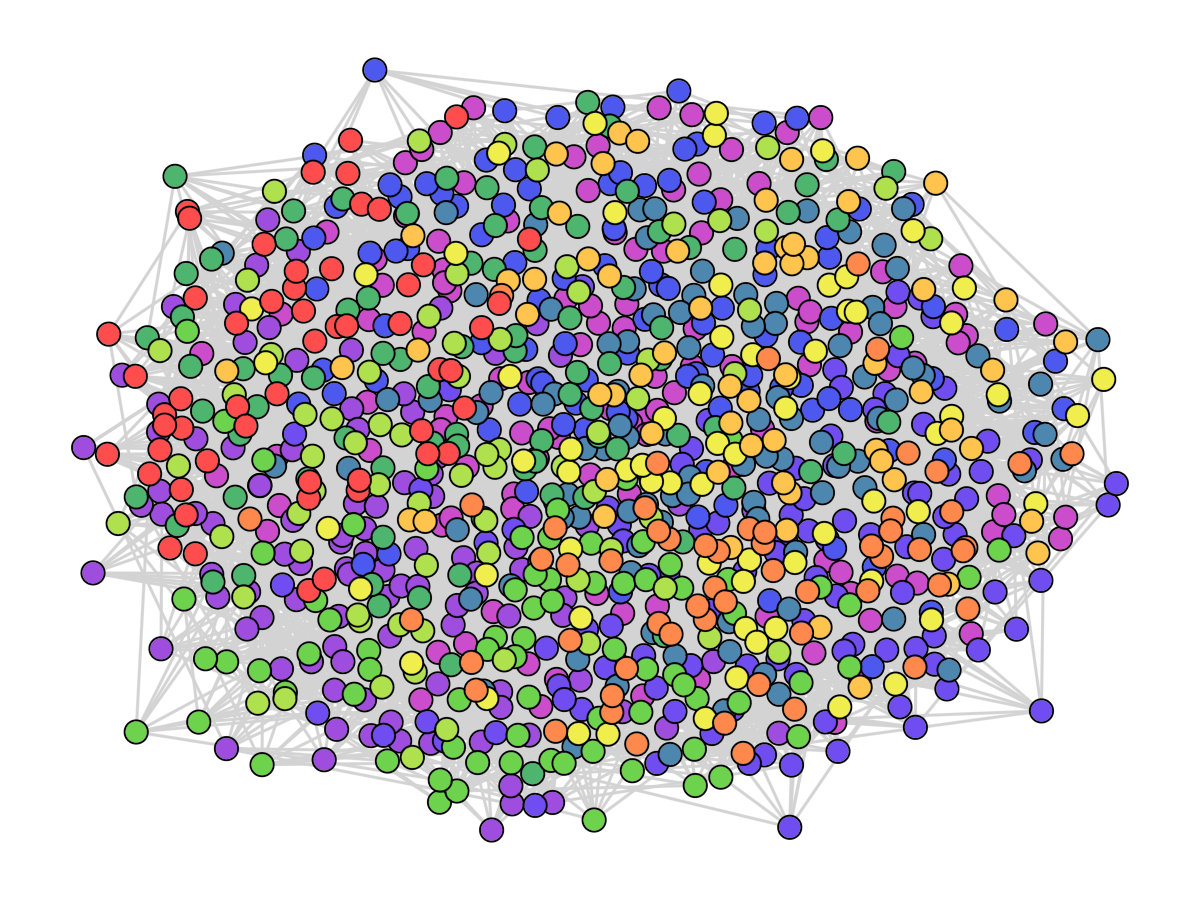

In [7]:
## read graph and communities
abcd_edgelist = readdlm(datadir * "abcd_1000.dat", Int)
c_abcd1 = readdlm(datadir * "abcd_1000_comms.dat", Int)[:, 2]
n = length(c_abcd1)

ABCD1 = SimpleGraph(n)
for row in eachrow(abcd_edgelist)
    add_edge!(ABCD1, row...)
end

## print a few stats
println(nv(ABCD1), " vertices, ", ne(ABCD1), " edges, ", "mean degree: ", mean(degree(ABCD1)),
    ", no. of communities: ", maximum(c_abcd1))

## define the colors and node sizes here
clean_graphplot(ABCD1,
    node_size=15,
    node_strokewidth=1,
    node_color=c_abcd1,
    node_attr=(colormap=:lightrainbow,),
    edge_color=:lightgray)

1000 vertices, 8678 edges, mean degree: 17.356, no. of communities: 12


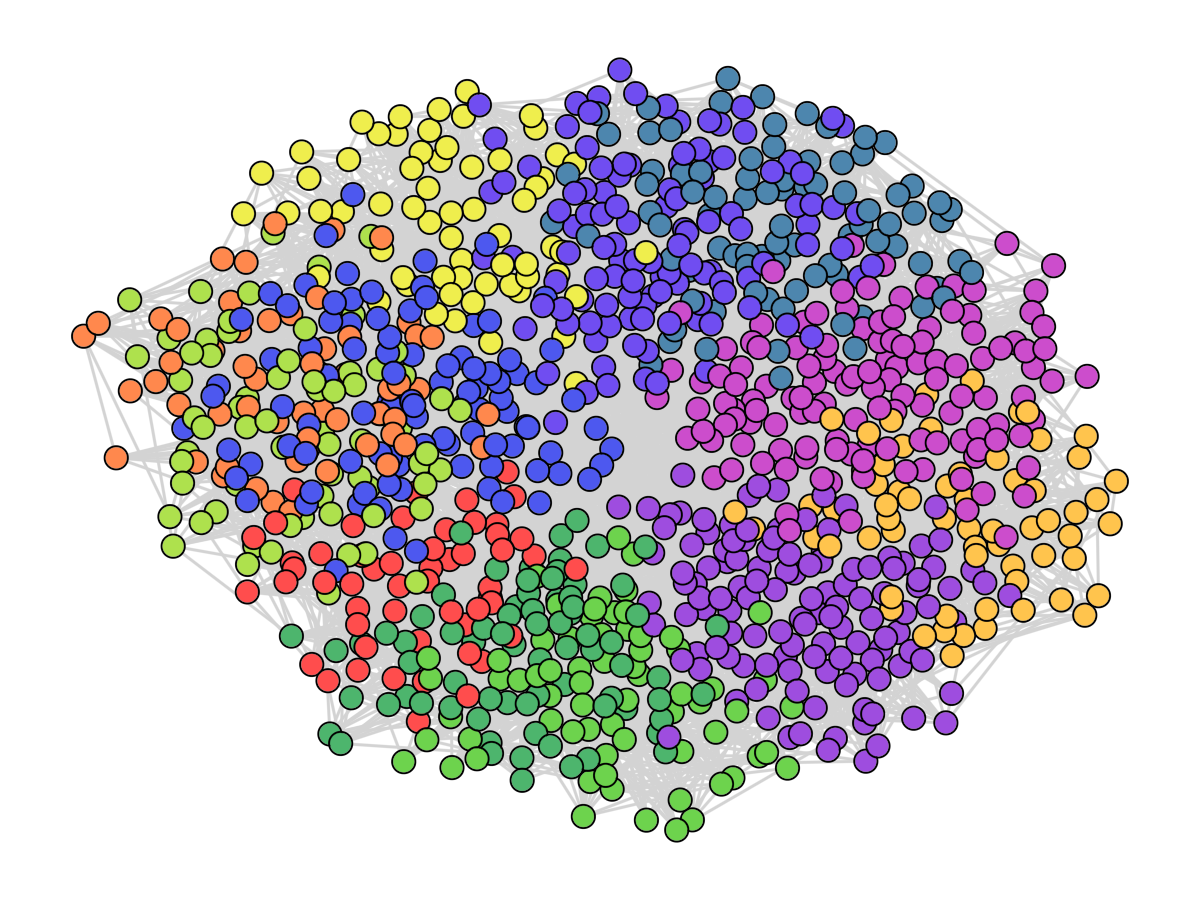

In [8]:
## read graph and communities
abcd_edgelist = readdlm(datadir * "abcd_1000_xi2.dat", Int)
c_abcd2 = readdlm(datadir * "abcd_1000_xi2_comms.dat", Int)[:, 2]
n = length(c_abcd2)

ABCD2 = SimpleGraph(n)
for row in eachrow(abcd_edgelist)
    add_edge!(ABCD2, row...)
end

## print a few stats
println(nv(ABCD2), " vertices, ", ne(ABCD2), " edges, ", "mean degree: ", mean(degree(ABCD2)),
    ", no. of communities: ", maximum(c_abcd2))

## define the colors and node sizes here
clean_graphplot(ABCD2,
    node_size=15,
    node_strokewidth=1,
    node_color=c_abcd2,
    node_attr=(colormap=:lightrainbow,),
    edge_color=:lightgray)

## Graph layouts 

We show a variety of graph layout functions available in `GraphMakie` on the Zachary graph.


### Zachary (karate club) graph


In [9]:
zac_edgelist = readdlm(datadir * "zachary.edgelist", Int) .+ 1
c = vec(readdlm(datadir * "zachary.communities", Int)) .+ 1
n = length(c)
zac = SimpleGraph(n)
add_edge!.(Ref(zac), zac_edgelist[:,1], zac_edgelist[:,2])
zac

{34, 78} undirected simple Int64 graph

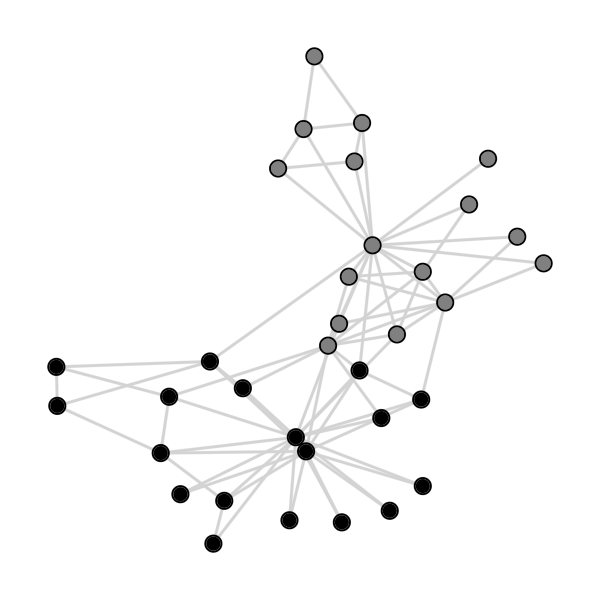

In [10]:
## Spring (repulsion) layout
clean_graphplot(zac,
    layout=Spring(),
    node_size=10,
    node_strokewidth=1,
    node_color=[:gray, :black][c],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

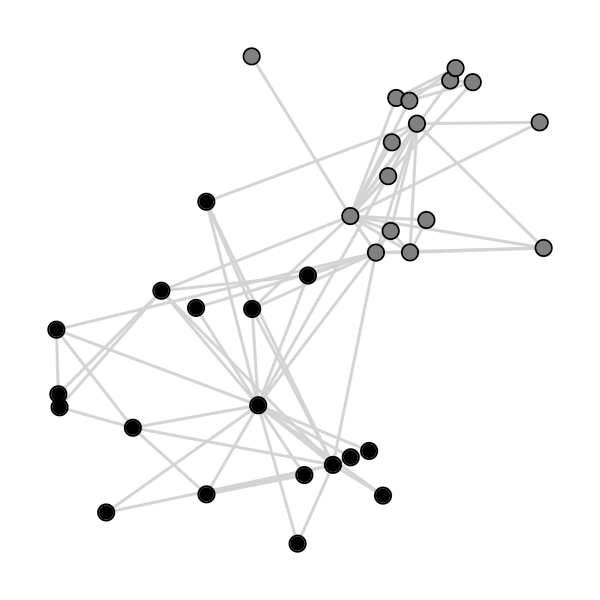

In [11]:
## Scalable Force Directed Placement layout
clean_graphplot(zac,
    layout=SFDP(),
    node_size=10,
    node_strokewidth=1,
    node_color=[:gray, :black][c],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

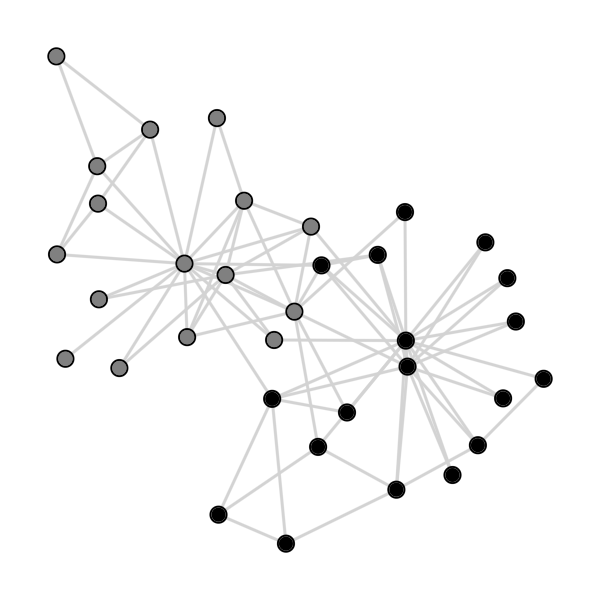

In [12]:
## Stress Majorization layout
clean_graphplot(zac,
    layout=Stress(),
    node_size=10,
    node_strokewidth=1,
    node_color=[:gray, :black][c],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

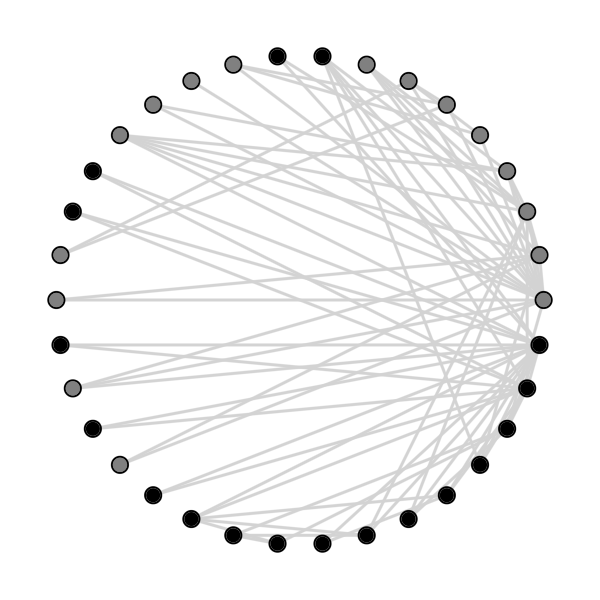

In [13]:
## Shell (circular) layout
clean_graphplot(zac,
    layout=Shell(),
    node_size=10,
    node_strokewidth=1,
    node_color=[:gray, :black][c],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

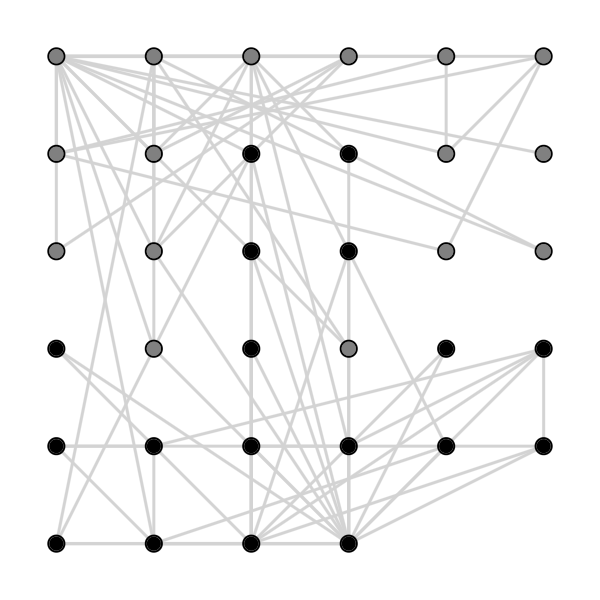

In [14]:
## Grid layout
clean_graphplot(zac,
    layout=SquareGrid(),
    node_size=10,
    node_strokewidth=1,
    node_color=[:gray, :black][c],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

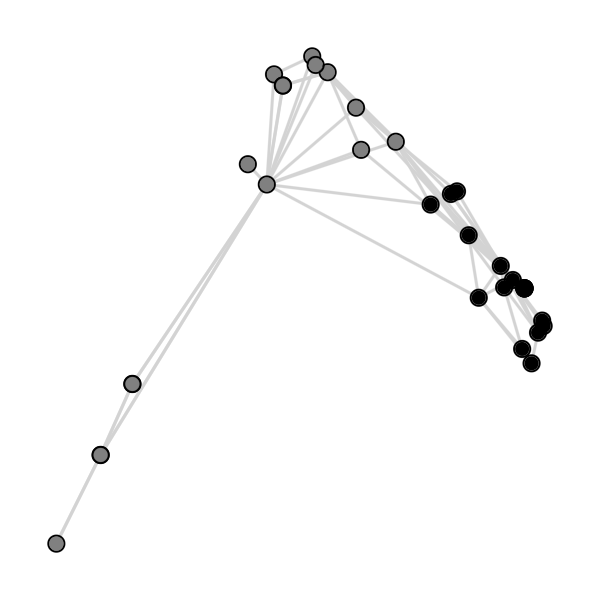

In [15]:
## Spectral layout
clean_graphplot(zac,
    layout=Spectral(dim=2),
    node_size=10,
    node_strokewidth=1,
    node_color=[:gray, :black][c],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

# Generate and compare several embeddings -- Zachary graph

We run a few graph embedding algorithms on the Zachary graph with
different parameters. 

For example, we try different embedding dimensions.

We run the following:
* node2vec with different values for $p$ and $q$
* HOPE with different similarities
* Laplacian Eigenmaps (LE)

For each embedding, we use the communities obtained with **ECG** along with the **CGE** framework to compute the **graph embedding divergence** with the **CGE** Julia package. We visualize some good and bad results w.r.t. the global divergence score.

For embeddings with low divergence, we see good separation of the communities (even in 2-dim projection, using **UMAP**), while this is not the case for embeddings with high divergence.

Since we are going to compare embeddings for several graphs, we write the procedure as a function below. This function keeps a local copy of the best (`_embed_best`) and worst (`_embed_worst`) embeddings on disk, and returns the JS divergence (including local) for every test.

In [16]:
#### compare several embedding methods
function test_embeddings(
    g,
    edgefile::String,
    commfile::String;
    run_hope::Bool=true,
    run_le::Bool=true,
    run_n2v::Bool=true,
    dims::Vector{Int}=[2, 4, 8],
    local_flag::Bool=false,
    verbose::Bool=true,
    seed::Int=123
)
    results = DataFrame(dim=Int[], algo=String[], param=String[], jsd=Float64[], local_jsd=Float64[])
    best_jsd = 1.0
    worst_jsd = 0.0

    if run_hope
        for dim in dims, sim in ["katz", "ppr", "cn", "aa"]
            x = Hope(g, sim, dim)
            saveEmbedding(x, g)
            div = JS(edgefile, commfile, "_embed")
            jsd = local_flag ? div[2] : div[1]
            if verbose
                println("HOPE: dim=$dim sim=$sim jsd=$jsd")
            end
            if jsd < best_jsd
                cp("_embed", "_embed_best", force=true)
                best_jsd = jsd
            end
            if jsd > worst_jsd
                cp("_embed", "_embed_worst", force=true)
                worst_jsd = jsd
            end
            push!(results, (dim=dim, algo="hope", param=sim, jsd=div[1], local_jsd=div[2]))
        end
    end

    if run_le
        for dim in dims
            x = LE(g, dim)
            saveEmbedding(x, g)
            div = JS(edgefile, commfile, "_embed")
            jsd = local_flag ? div[2] : div[1]
            if verbose
                println("LE: dim=$dim jsd=$jsd")
            end
            if jsd < best_jsd
                cp("_embed", "_embed_best", force=true)
                best_jsd = jsd
            end
            if jsd > worst_jsd
                cp("_embed", "_embed_worst", force=true)
                worst_jsd = jsd
            end
            push!(results, (dim=dim, algo="le", param=" ", jsd=div[1], local_jsd=div[2]))
        end
    end

    if run_n2v
        for dim in dims, (p, q) in [(1, 0.5), (0.5, 1), (1, 1)]
            @pyexec (edgelist_filepath=edgefile,dim=dim,p=p,q=q,seed=seed) => """
            import fastnode2vec as n2v
            import numpy as np
            global nv
            data = np.loadtxt(edgelist_filepath)
            graph = n2v.Graph(data, directed=False, weighted=False)
            nv = n2v.Node2Vec(graph, dim=int(dim), p=np.float64(p), q=np.float64(q), walk_length=80, window=5, seed=int(seed))
            nv.train(epochs=10, verbose=False)
            Y = np.array([nv.wv[i] for i in range(len(nv.wv))])
            with open('_embed','w') as f:
                nid=0
                f.write(str(Y.shape[0]) + " " + str(Y.shape[1])+'\\n')
                for i in range(Y.shape[0]):
                    f.write(str(nid)+' ')
                    for j in range(Y.shape[1]):
                        f.write(str(Y[i][j])+' ')
                    f.write('\\n')
                    nid+=1
            """
            div = JS(edgefile, commfile, "_embed")
            jsd = local_flag ? div[2] : div[1]
            if verbose
                println("n2v: dim=$dim p=$p q=$q jsd=$jsd")
            end
            if jsd < best_jsd
                cp("_embed", "_embed_best", force=true)
                best_jsd = jsd
            end
            if jsd > worst_jsd
                cp("_embed", "_embed_worst", force=true)
                worst_jsd = jsd
            end
            push!(results, (dim=dim, algo="n2v", param="$p $q", jsd=div[1], local_jsd=div[2]))
        end
    end

    if local_flag
        sort!(results, :local_jsd)
    else
        sort!(results, :jsd)
    end
    return results
end


test_embeddings (generic function with 1 method)

The code below takes about one minute to run as several embeddings are tested.


In [17]:
D = test_embeddings(zac,
    datadir * "zachary.edgelist",
    datadir * "zachary.ecg",
    dims=[2, 4])
first(D, 5)

HOPE: dim=2 sim=katz jsd=0.012030932588247091
HOPE: dim=2 sim=ppr jsd=0.006765919439249928
HOPE: dim=2 sim=cn jsd=0.011642260200926482
HOPE: dim=2 sim=aa jsd=0.02523815528739714
HOPE: dim=4 sim=katz jsd=0.01394006540926778
HOPE: dim=4 sim=ppr jsd=0.007719751141632848
HOPE: dim=4 sim=cn jsd=0.013774754577886263
HOPE: dim=4 sim=aa jsd=0.012916556563146213
LE: dim=2 jsd=0.008543633514461167
LE: dim=4 jsd=0.006274360431422854


n2v: dim=2 p=1 q=0.5 jsd=0.012409041271712343


n2v: dim=2 p=0.5 q=1 jsd=0.019932328700023087


n2v: dim=2 p=1 q=1 jsd=0.003307234282473706


n2v: dim=4 p=1 q=0.5 jsd=0.0054673665176852545


n2v: dim=4 p=0.5 q=1 jsd=0.007211045454541989


n2v: dim=4 p=1 q=1 jsd=0.006949504203024858


5×5 DataFrame
 Row │ dim    algo    param   jsd         local_jsd 
     │ Int64  String  String  Float64     Float64   
─────┼──────────────────────────────────────────────
   1 │     2  n2v     1 1     0.00330723     0.0764
   2 │     4  n2v     1 0.5   0.00546737     0.0484
   3 │     4  le              0.00627436     0.0237
   4 │     2  hope    ppr     0.00676592     0.0884
   5 │     4  n2v     1 1     0.0069495      0.0354

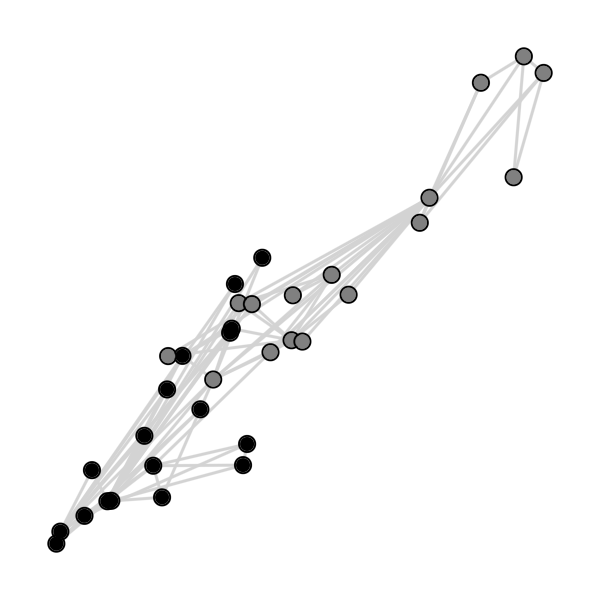

In [18]:
## plot top results
l = embed2layout("_embed_best", 123)
clean_graphplot(zac,
    layout=l,
    node_size=10,
    node_strokewidth=1,
    node_color=[:gray, :black][c],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

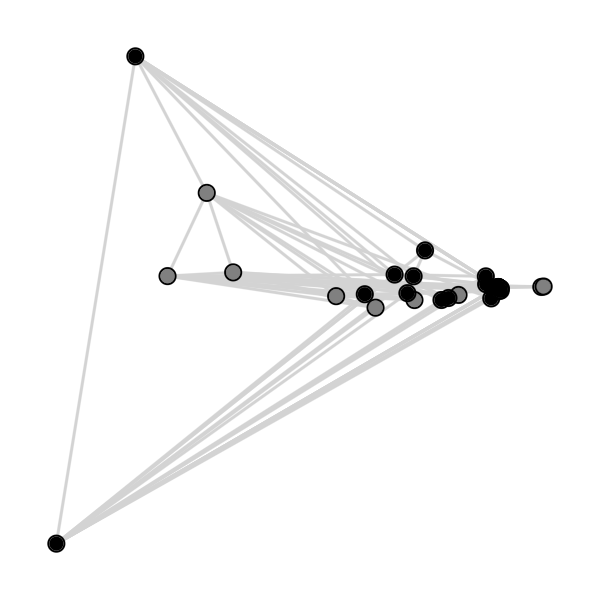

In [19]:
## plot result with largest divergence
l = embed2layout("_embed_worst", 123)
clean_graphplot(zac,
    layout=l,
    node_size=10,
    node_strokewidth=1,
    node_color=[:gray, :black][c],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

# Compare embeddings - small ABCD  graph

This is the same exercise as what we did above, this time for the 100-nodes ABCD graph.

We look at slightly higher embedding dimension as there are more nodes than the Zachary graph.


### effect of local divergence score

So far we considered the global Jenssen-Shannon divergence, where the objective is to preserve the community structure.

We show the best result with respect to the global divergence below, and we see that it preserves the community structure. We may want better separation of the nodes within community, based on their connectivity. This is what the local Jenssen-Shannon divergence can provide. 

Below we also show an embedding with lower local divergence. The result is an embedding that still preserves community structure, but nodes within community are more separated than with the global divergence.

The code below takes about one minute to run as several embeddings are tested.


In [ ]:
results = test_embeddings(abcd,
    datadir * "abcd_100.dat",
    datadir * "abcd_100.ecg",
    dims=[2, 16])
first(D, 5)

HOPE: dim=2 sim=katz jsd=0.037300643543246526
HOPE: dim=2 sim=ppr jsd=0.03143740251467622


In [ ]:
Plots.scatter(results.jsd ./ minimum(results.jsd), 
        results.local_jsd ./ minimum(results.local_jsd),
        xaxis = (:log2, "Global divergence score (normalized)"),
        yaxis = (:log2, "Local divergence score (normalized)"),
        color = :black,
        markerstrokewidth = 0,
        label = "",
        guidefontsize = 11)

In [ ]:
## plot result with lowest global JS divergence
l = embed2layout("_embed_best", 123)
clean_graphplot(abcd,
    layout=l,
    node_size=10,
    node_strokewidth=1,
    node_color=[:white, :lightgray, :black][c_abcd],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

In [ ]:
## look at results with low local divergence
first(sort(D, "local_jsd"), 5)

In [ ]:
## Plot one of the top ones
x = Hope(abcd, "ppr", 16)
saveEmbedding(x, abcd)
l = embed2layout("_embed", 123)
clean_graphplot(abcd,
    layout=l,
    node_size=10,
    node_strokewidth=1,
    node_color=[:white, :lightgray, :black][c_abcd],
    edge_color=:lightgray,
    figure=(size=(300, 300),))

In [ ]:
last(D, 5)

In [ ]:
## Plot one of the bottom ones
x = Hope(abcd, "katz", 2)
saveEmbedding(x, abcd)
l = embed2layout("_embed", 123)
clean_graphplot(abcd,
    layout=l,
    node_size=10,
    node_strokewidth=1,
    node_color=[:white, :lightgray, :black][c_abcd],
    edge_color=:lightgray,
    figure=(size=(300, 300),))